In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statistics
#from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.ar_model import AR
#from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
#from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

df_daily = pd.read_csv("DailyEnergyConsumption_df.csv").set_index("Datetime")
df_weekly = pd.read_csv("WeekyEnergyConsumption_df.csv").set_index("Datetime")

In [2]:
df_weekly.head()

,Total_MW,Weeks
Datetime,,
2012-01-01,46188.163043,1
2012-01-08,54688.875000,2
2012-01-15,55755.767857,3
2012-01-22,57336.458333,4
2012-01-29,53328.892857,5


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    
    #input sequence...
    for i in range(n_in, 0,1):
        cols.append(df.shift(i))
    
    #forecast squence...
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

def train_test_split(data, n_test):
    return data[:-n_test,:], data[-n_test:,:]

def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:,:-1], train[:,-1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset, train | test
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    #error = mean_absolute_error(test[:, -1], predictions)
    rmse = sqrt(mean_squared_error(test[:, -1], predictions))
    return rmse, test[:, -1], predictions

In [4]:
df_W = df_weekly.reset_index()
df_W.head()
df = df_W[['Weeks', 'Total_MW']]
df.head()

,Weeks,Total_MW
0,1,46188.163043
1,2,54688.875000
2,3,55755.767857
3,4,57336.458333
4,5,53328.892857


>expected=57730.2, predicted=51374.4
>expected=55231.4, predicted=55563.6
>expected=49641.4, predicted=55286.4
>expected=52380.2, predicted=51636.1
>expected=55097.7, predicted=52127.7
>expected=50857.2, predicted=54056.5
>expected=49892.1, predicted=52078.6
>expected=46148.8, predicted=50709.8
>expected=50003.3, predicted=47759.0
>expected=49242.3, predicted=49185.0
>expected=54472.2, predicted=49200.5
>expected=47257.8, predicted=52569.4
>expected=45016.8, predicted=49288.0
>expected=45498.6, predicted=46614.8
>expected=43414.1, predicted=45935.9
>expected=44255.7, predicted=44375.7
>expected=45883.1, predicted=44222.6
>expected=44290.2, predicted=45317.6
>expected=43809.9, predicted=44633.3
>expected=49504.8, predicted=44095.0
>expected=44967.1, predicted=47489.8
>expected=48259.0, predicted=45875.9
>expected=49987.1, predicted=47437.4
>expected=60468.1, predicted=49024.3
>expected=54386.2, predicted=56591.3
>expected=52781.0, predicted=55029.9
>expected=55310.3, predicted=53665.8
>

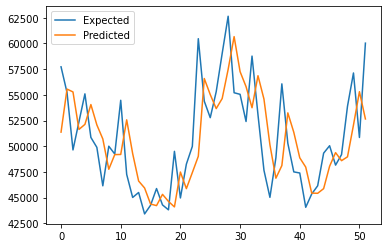

In [5]:
values = df.values
data = series_to_supervised(values, n_in=6)

rmse, y, yhat = walk_forward_validation(data, 52)
print('RMSE: %.3f' % rmse)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

*Random Forest Regressor improves on the accuracy of the forecast compared to the "persistence" model*

>expected=54577.1, predicted=47857.0
>expected=57126.9, predicted=52074.5
>expected=62867.8, predicted=55258.4
>expected=54131.5, predicted=60188.2
>expected=51511.6, predicted=56253.3
>expected=60604.7, predicted=53391.1
>expected=52920.3, predicted=57758.6
>expected=51055.1, predicted=54666.3
>expected=51659.8, predicted=52365.0
>expected=45389.2, predicted=51883.5
>expected=45670.8, predicted=47962.3
>expected=45032.4, predicted=46449.9
>expected=44869.7, predicted=45530.7
>expected=48510.4, predicted=45159.8
>expected=44917.7, predicted=47233.4
>expected=43745.6, predicted=45806.1
>expected=44314.7, predicted=44500.4
>expected=43481.5, predicted=44365.7
>expected=44061.9, predicted=43796.0
>expected=43445.1, predicted=43968.3
>expected=51105.7, predicted=43643.5
>expected=52495.2, predicted=48253.9
>expected=51922.0, predicted=50957.9
>expected=54636.0, predicted=51591.6
>expected=57388.1, predicted=53426.8
>expected=52251.0, predicted=55967.5
>expected=56467.6, predicted=53628.7
>

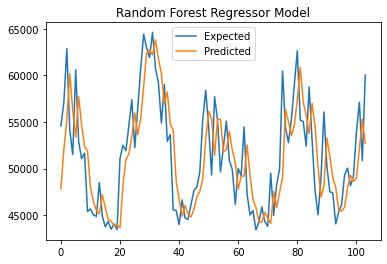

In [27]:
data = series_to_supervised(values, n_in=10)

rmse, y, yhat = walk_forward_validation(data, 104)
print('RMSE: %.3f' % rmse)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.title("Random Forest Regressor Model")
plt.legend()
plt.show()